# load libraries and paths

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import h5py
import numpy as np
import nibabel as nib
import logging
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import os
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
import seaborn as sns

In [14]:
allRuns = [ 'test1_901', 'test2_1101', 'test3_1301', 'test4_1501', 'test5_1701', 'test6_1901', 'test7_2101', 'test8_2301']
nnodes = 59412
nregions = 360
target_parcels = list(range(1,361)) 
target_networks = list(range(1,13))
nnetworks = 12
relevantConds = ['Practice_Cong_NEXT','Practice_Incong_NEXT', 'Novel_Cong_NEXT', 'Novel_Incong_NEXT']

networkmappings = {'vis1':1, 'vis2':2, 'smn':3,'con':4, 'dan':5,'lan':6,'fpn':7,'aud':8, 'dmn':9, 
                   'pmulti':10, 'vmm':11, 'ora':12}  

In [3]:
subjNums = [ 'sub-3', 'sub-4', 'sub-5', 'sub-6', 'sub-7', 'sub-8', 'sub-10', 
         'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20',
           'sub-21', 'sub-22', 'sub-23', 'sub-24', 'sub-25', 'sub-26', 'sub-28', 'sub-29', 'sub-30',
          'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37', 'sub-38', 'sub-39', 'sub-40']

In [4]:
actual_data_dir = '/projects/f_mc1689_1/MeiranNext/data/results/ArunResults/ActualBetasParcelwiseH5/'
actual_suffix = '_actualBetas.h5' 

In [5]:
networkpartition_dir = '/projects/f_mc1689_1/AnalysisTools/ActflowToolbox/dependencies/ColeAnticevicNetPartition/'
networkdef = np.loadtxt(networkpartition_dir + 'cortex_parcel_network_assignments.txt') #1 based 

dlabelfile = '/projects/f_mc1689_1/AnalysisTools/ActflowToolbox/dependencies/ColeAnticevicNetPartition/CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR.dlabel.nii'
dlabels = np.squeeze(nib.load(dlabelfile).get_fdata()) # whole brain, 91282 vertices, 1 based not 0 based
dlabels = dlabels[:nnodes]


vertex_networks = np.zeros(dlabels.shape, dtype=int)
for i in range(nregions):
    parcel_indices = np.where(dlabels == (i + 1))  
    vertex_networks[parcel_indices] = networkdef[i]

In [6]:
np.unique(networkdef)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

# load actual betas

In [7]:
def LoadActualBetas(subj, input_network):
    ActualActivationVecLeft = []
    ActualActivationVecRight = []

    h5_path = actual_data_dir + subj + actual_suffix

    try:
        with h5py.File(h5_path, 'r') as h5f:
            for run in allRuns:
                if run not in h5f:
                    # logging.warning(f"Run {run} missing for {subj}")
                    continue

                for miniblock_key in h5f[run]:
                    mb = h5f[run][miniblock_key]
                    
                    # Skip miniblocks with no motor_response field
                    if 'motor_response' not in mb:
                        continue
                    
                    conditions = [c.decode('utf-8') for c in mb['condition']]
                    betas = mb['betas'][:]
                    
                    motor_resp = [r.decode('utf-8') for r in mb['motor_response']] 

                    for i, cond in enumerate(conditions):
                        if 'GO' in cond:
                            goBetas = betas[i].astype(np.float32, copy=False)
                            button = motor_resp[i]

                            if goBetas.shape[0] != len(networkdef):
                                raise ValueError("Mismatch between GOBetas and networkdef dimensions.")

                            input_mask = (networkdef == input_network)

                            if button == 'left':
                                actVectLeft = goBetas[input_mask]
                                if actVectLeft.size > 0:
                                    ActualActivationVecLeft.append(actVectLeft)

                            elif button == 'right':
                                actVectRight = goBetas[input_mask]
                                if actVectRight.size > 0:
                                    ActualActivationVecRight.append(actVectRight)
    except Exception as e:
        logging.error(f"Failed to process subject {subj} in LoadTemplateActual: {e}")

    if ActualActivationVecLeft:
        ActualActivationVecLeft = np.vstack(ActualActivationVecLeft)
    else:
        ActualActivationVecLeft = None

    if ActualActivationVecRight:
        ActualActivationVecRight = np.vstack(ActualActivationVecRight)
    else:
        ActualActivationVecRight = None

    return ActualActivationVecLeft, ActualActivationVecRight


# Group level networkwise PCA 

In [22]:
def performPCA(input_network):
    avg_left_all = []
    avg_right_all = []

    for subj in subjNums:
        left_betas, right_betas = LoadActualBetas(subj, input_network)

        # Skip subjects with missing data
        if left_betas is None or right_betas is None:
            continue
        if len(left_betas) == 0 or len(right_betas) == 0:
            continue

        avg_left = np.mean(left_betas, axis=0)
        avg_right = np.mean(right_betas, axis=0)

        avg_left_all.append(avg_left)
        avg_right_all.append(avg_right)
        
    X_group = np.vstack([avg_left_all, avg_right_all])  # shape: (nSubjects*2, nRegions)
    y_group = np.array([0]*len(avg_left_all) + [1]*len(avg_right_all))  # 0=left, 1=right
    
    pca_group = PCA(n_components=3)
    X_group_pca = pca_group.fit_transform(X_group)
    
    plt.figure(figsize = (3,3))
    plt.bar(range(1, 4), pca_group.explained_variance_ratio_[:3] * 100)
    plt.xticks([1, 2, 3], ['PC1', 'PC2', 'PC3'])
    plt.ylabel('% Variance Explained')
    plt.title(f'Explained Variance by PCs for {list(networkmappings.keys())[input_network-1]} network')
    plt.show()
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X_group_pca[y_group == 0, 0], X_group_pca[y_group == 0, 1], X_group_pca[y_group == 0, 2], label='Left Avg', alpha=0.8)
    ax.scatter(X_group_pca[y_group == 1, 0], X_group_pca[y_group == 1, 1], X_group_pca[y_group == 1, 2], label='Right Avg', alpha=0.8)

    ax.set_title(f'Group-Level PCA for {list(networkmappings.keys())[input_network-1]} network')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()
    plt.tight_layout()
    plt.show()


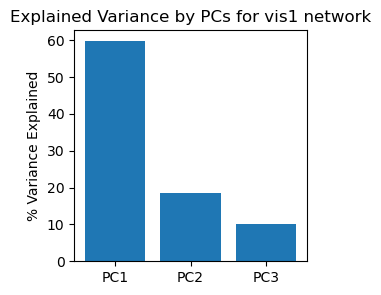

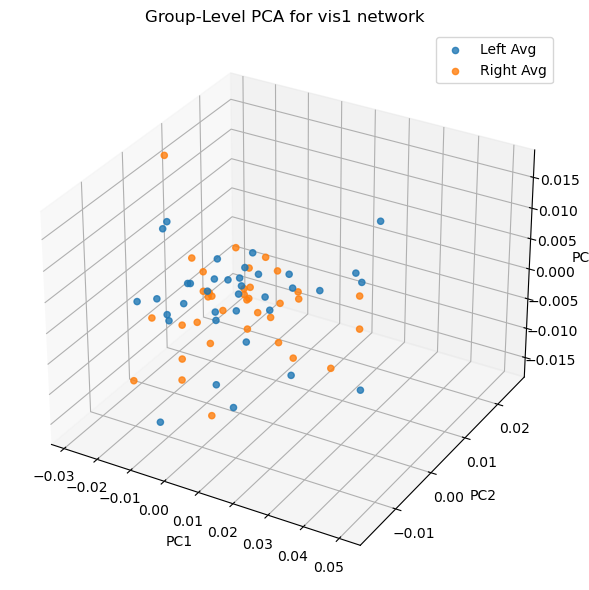

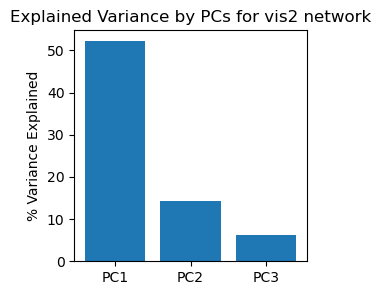

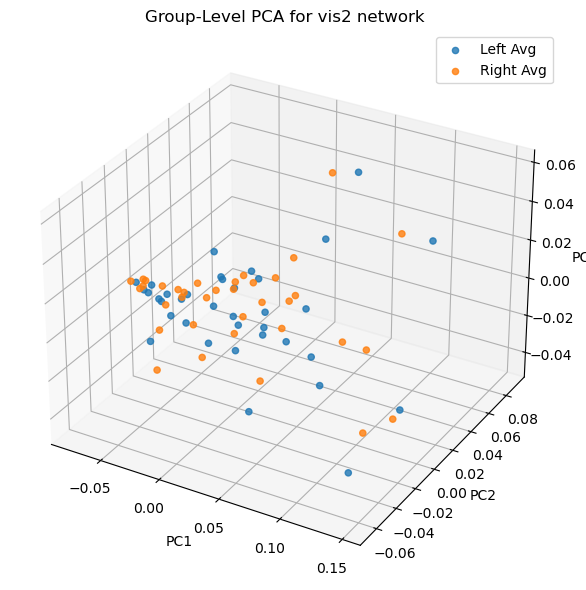

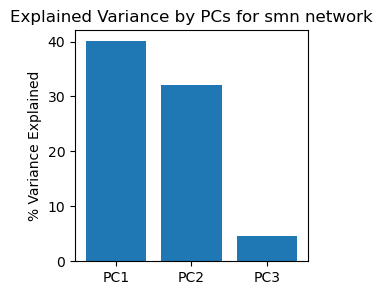

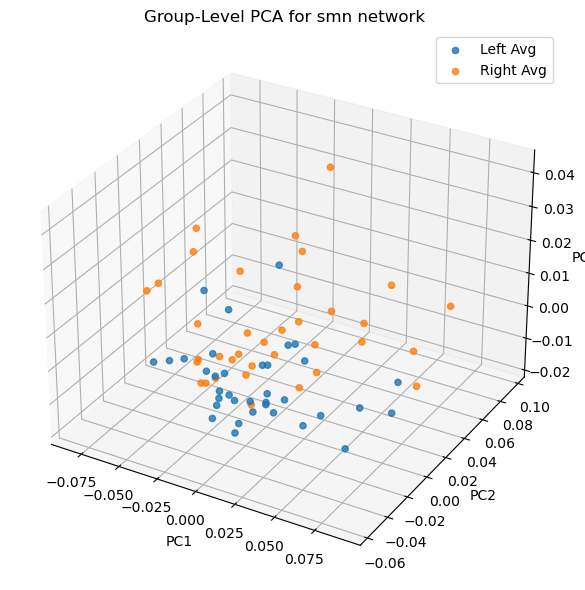

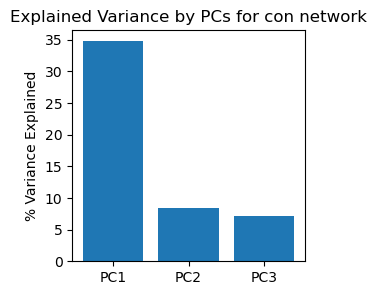

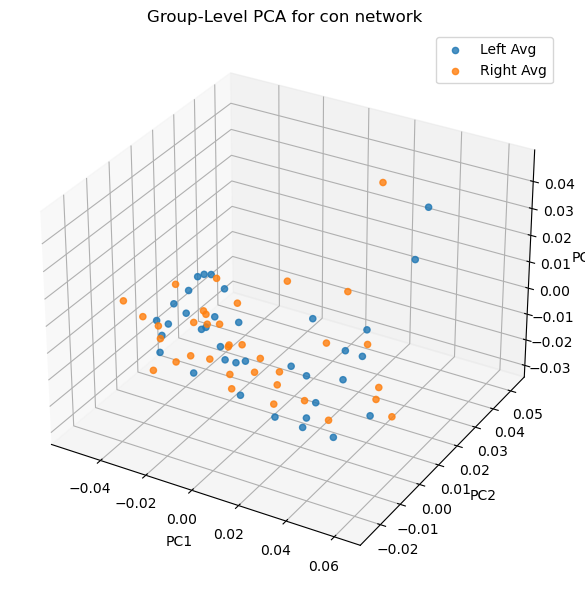

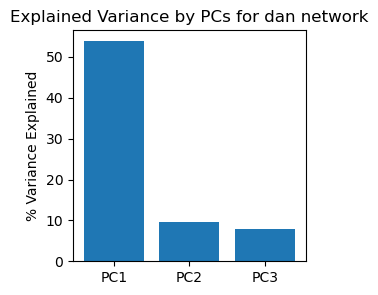

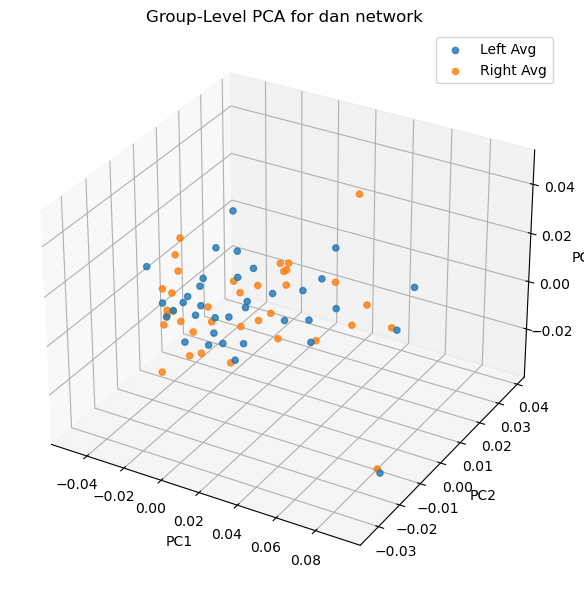

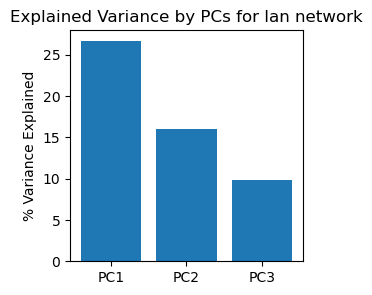

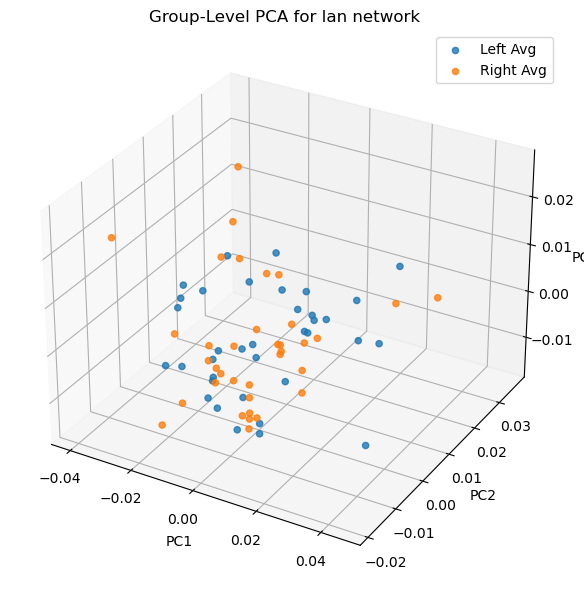

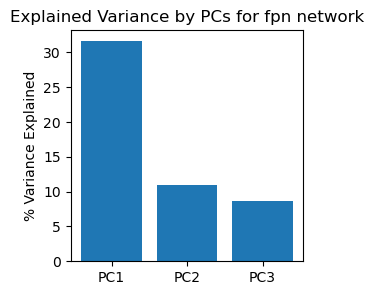

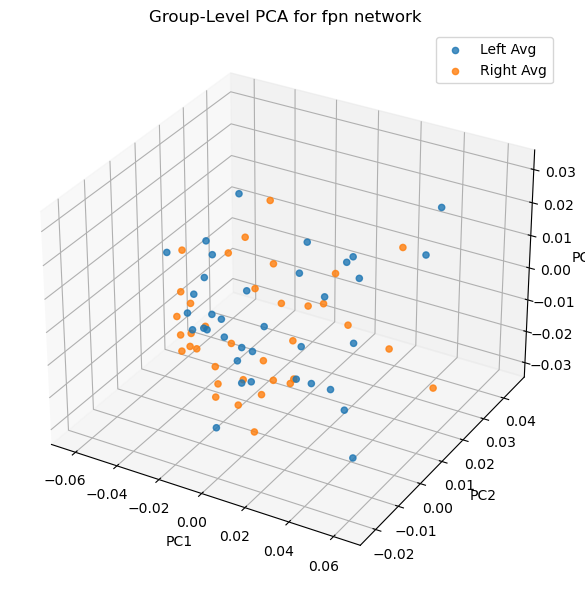

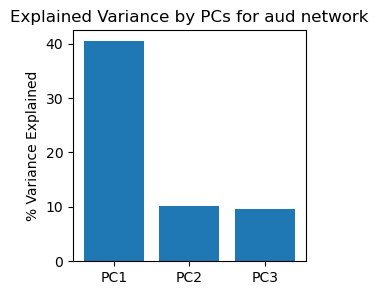

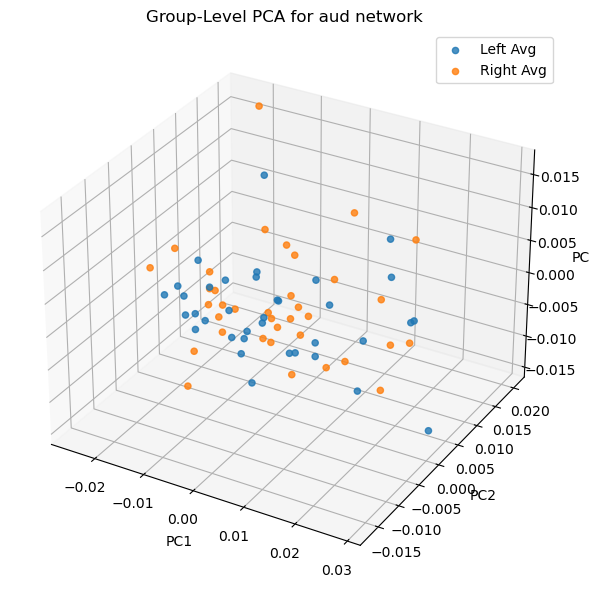

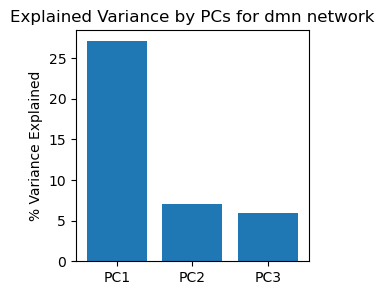

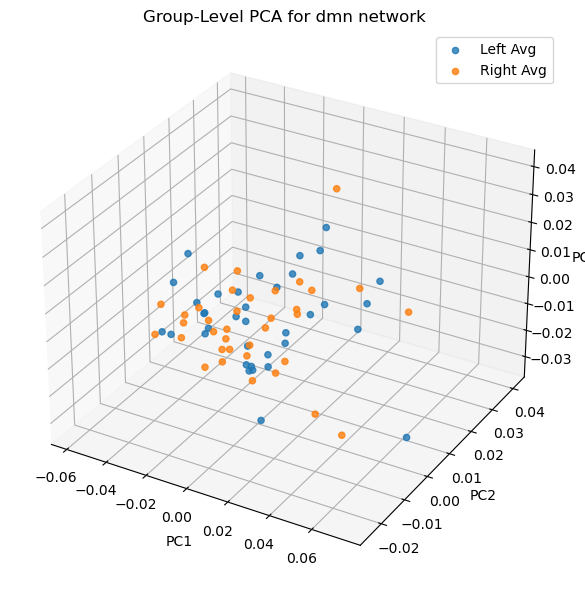

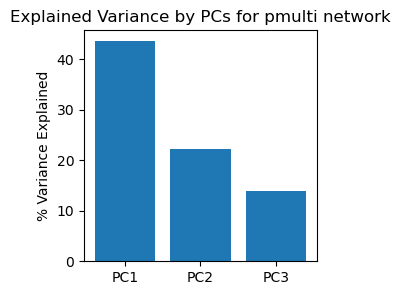

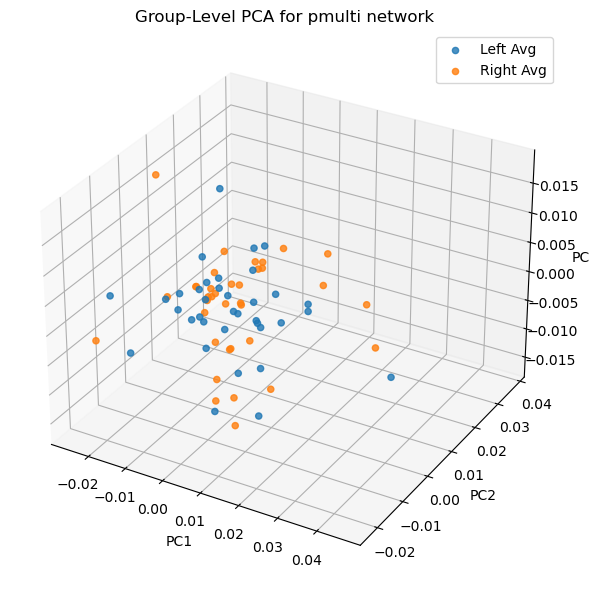

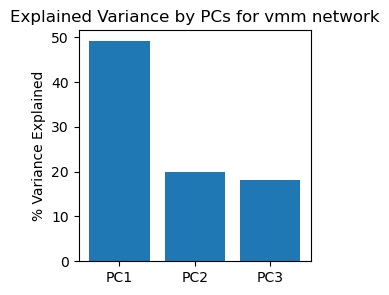

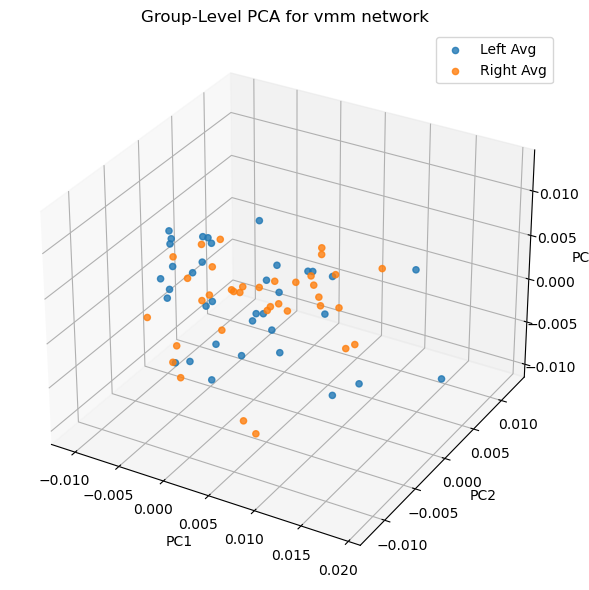

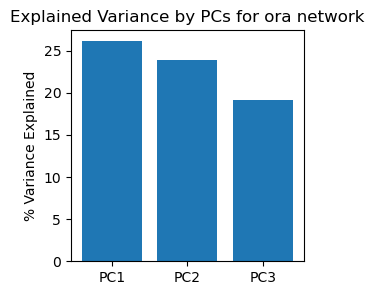

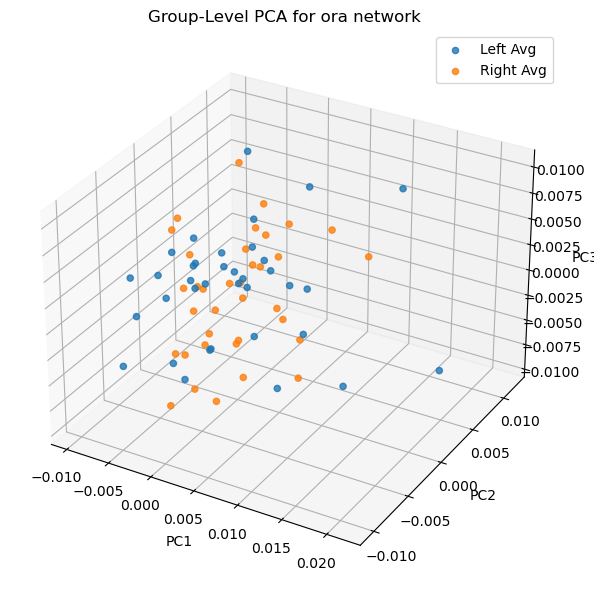

In [23]:
for network in range(1, 13):
    performPCA(input_network = network)
    

# Actual betas decoding (ground truth)

In [25]:
def CVcorr(subj, input_network):
    # Load actual and predicted betas grouped by congruency.
    actual_left, actual_right = LoadActualBetas(subj, input_network)
    
    # Concatenate the actual betas for training.
    X = np.concatenate((actual_left, actual_right), axis=0)  
    
    # Create a label array: 'L' for left and 'R' for right.
    y = np.array(['L'] * len(actual_left) + ['R'] * len(actual_right))
    
    # Set up k-fold cross-validation (e.g., 5 folds)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    correct_predictions_total = 0
    total_samples = 0

    # Loop over each fold
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]  # Split betas
        y_train, y_test = y[train_index], y[test_index]  # Split labels

        # Separate the training set into left and right based on the labels
        left_train = X_train[y_train == 'L']
        right_train = X_train[y_train == 'R']

        # Compute the mean template vectors for left and right presses using the training set
        template_left = np.mean(left_train, axis=0)  # Mean across trials
        template_right = np.mean(right_train, axis=0)  # Mean across trials

        # Classify the test set by comparing each test trial to the templates
        decode = []
        for sample in range(len(X_test)):
            # Compute correlations with left and right templates
            corr_left = np.corrcoef(X_test[sample], template_left)[0, 1]
            corr_right = np.corrcoef(X_test[sample], template_right)[0, 1]

            # Classify based on which correlation is higher
            if corr_left > corr_right:
                decode.append('L')
            else:
                decode.append('R')

        # Calculate accuracy for this fold
        correct_predictions = np.sum(np.array(decode) == y_test)
        fold_accuracy = correct_predictions / len(y_test)
        cv_scores.append(fold_accuracy)
        correct_predictions_total += correct_predictions
        total_samples += len(y_test)
        
    avg_acc = np.mean(cv_scores)
    return avg_acc

def process_network(subj, input_network):
    avg_acc = CVcorr(subj, input_network)
    return avg_acc

# Parallelize processing across subjects and parcels.
def process_subject(subj):
    network_wise_subj = Parallel(n_jobs=-1)(
        delayed(process_network)(subj, input_network) 
        for input_network in target_networks
    )
    print(f"Finished running subject: {subj}")
    return network_wise_subj

# Run all subjects in parallel.
subject_network_accuracy = Parallel(n_jobs=-1)(
    delayed(process_subject)(subj) for subj in subjNums
)


# Bar plot of ground truth grouped by network

All networks have p-values.


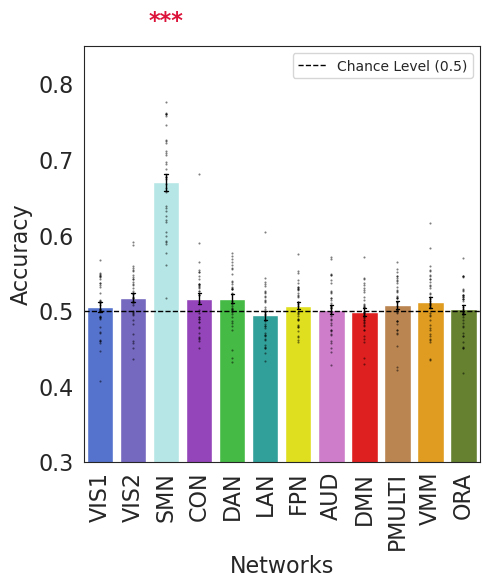

In [36]:
subject_network_accuracy = np.array(subject_network_accuracy)

# Ensure accuracies are between 0 and 1
subject_network_accuracy = np.clip(subject_network_accuracy, 0, 1)

networks = list(networkmappings.items())
network_labels = [name.upper() for name, idx in networks]

# 1.2. Assign the provided network palette
networkpalette = ['royalblue', 'slateblue', 'paleturquoise', 'darkorchid', 'limegreen',
                 'lightseagreen', 'yellow', 'orchid', 'red', 'peru', 'orange', 'olivedrab']

# Ensure the number of networks matches the palette length
assert len(network_labels) == len(networkpalette), "Number of networks and palette colors must match."

# 1.3. Perform wilcoxon-signed test per network against chance level (0.5)
chance_level = 0.5
t_stat_netwise = []
p_val_netwise = []

for i in range(subject_network_accuracy.shape[1]):
    # Extract the accuracies for the current network across all subjects
    network_accuracies = subject_network_accuracy[:, i]
    
    # Identify the subjects with valid (non-NaN) accuracy values
    valid = ~np.isnan(network_accuracies)
    if not np.any(valid):
        # If no subject has a valid value, assign a non-significant p-value
        t_stat_netwise.append(np.nan)
        p_val_netwise.append(1.0)
        continue
    
    # Compute the differences from chance level (0.5)
    differences = network_accuracies[valid] - chance_level
    
    # Perform the Wilcoxon signed-rank test on the differences
    stat, p_value = wilcoxon(differences)
    
    # Append the test statistic and p-value to the lists
    t_stat_netwise.append(stat)
    p_val_netwise.append(p_value)
    
    

# 1.4. Apply Bonferroni correction for multiple comparisons
_, p_val_corrected, _, _ = multipletests(p_val_netwise, method='bonferroni')

# 1.5. Create DataFrame from the accuracies without sorting
df_accuracy = pd.DataFrame(subject_network_accuracy, columns=network_labels)
df_accuracy['Subject'] = np.arange(1, subject_network_accuracy.shape[0] + 1)

# 1.6. Melt the DataFrame to long format for seaborn plotting
df_melted = df_accuracy.melt(id_vars=['Subject'], var_name='Network', value_name='Accuracy')

# 1.7. Map corrected p-values to networks
network_p_values_corrected = dict(zip(network_labels, p_val_corrected))

# 1.8. Verify that all networks have a p-value
missing_p_values = [network for network in network_labels if network not in network_p_values_corrected]
if missing_p_values:
    print(f"Missing p-values for networks: {missing_p_values}")
else:
    print("All networks have p-values.")

# 1.9. Add 'p-value' column to the melted DataFrame
df_melted['p-value'] = df_melted['Network'].map(network_p_values_corrected)

# 1.10. Check if 'p-value' column has NaNs
if df_melted['p-value'].isnull().any():
    missing_networks = df_melted[df_melted['p-value'].isnull()]['Network'].unique()
    print(f"Warning: Missing p-values for networks: {missing_networks}")
    # Handle missing p-values if necessary
    # For now, fill NaN p-values with 1 (non-significant)
    df_melted['p-value'] = df_melted['p-value'].fillna(1)

# 1.11. Function to map p-values to significance levels
def significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# 1.12. Add 'Significance' column based on corrected p-values
df_melted['Significance'] = df_melted['p-value'].apply(significance_stars)

# 1.13. Calculate mean accuracies and SEM per network
mean_accuracy_per_network = df_melted.groupby('Network')['Accuracy'].mean()
sem_accuracy_per_network = df_melted.groupby('Network')['Accuracy'].sem()


# 2.1. Define a dictionary mapping networks to vibrant colors (provided palette)
network_significance_colors = {network: color for network, color in zip(network_labels, networkpalette)}

# 2.2. Calculate means and SEMs manually
means = mean_accuracy_per_network.values
sems = sem_accuracy_per_network.values

# 2.3. Set Seaborn style to 'white' to minimize grid lines
sns.set_style("white")

# 2.4. Create the bar plot with SEM manually
plt.figure(figsize=(5,6))  # Adjusted figure size for better visibility
ax = sns.barplot(
    x='Network',
    y='Accuracy',
    data=df_melted,
    palette=networkpalette,
    edgecolor=None,
    errorbar='se',
    capsize = 0.1,
    errcolor = 'black',
    errwidth = 1
)


# 2.5. Overlay individual data points using stripplot
sns.stripplot(
    x='Network',
    y='Accuracy',
    data=df_melted,
    color='black',
    alpha=0.5,
    jitter=False,
    size=1.5
)

# 2.6. Add significance stars with black color
# Calculate the y-position for each star based on max accuracy + offset
max_accuracy_per_network = df_melted.groupby('Network')['Accuracy'].max()

for i, network in enumerate(network_labels):
    stars = significance_stars(network_p_values_corrected[network])
    if stars:  # Only add stars if there is significance
        # Get the y-position: max accuracy + 30% of the y-axis range
        y_max = max_accuracy_per_network[network]
        y_range = df_melted['Accuracy'].max() - df_melted['Accuracy'].min()
        y_offset = y_range * 0.25
        y = y_max + y_offset
        # Set the stars color to black
        star_color = '#DC143C'
        # Add the text
        ax.text(
            i, y, stars,
            ha='center',
            va='bottom',
            color=star_color,
            fontsize=16,
            fontweight='bold'
        )

plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1, label='Chance Level (0.5)')

ax.set_xticklabels(network_labels, fontsize=16, rotation=90)  # Set rotation to 45 degrees
plt.xlabel('Networks', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
ax.tick_params(axis='y', labelsize=16)
# 2.9. Remove horizontal grid lines
ax.yaxis.grid(False)  # This removes the horizontal grid lines
ax.set_ylim(0.3, 0.85)  # Set y-axis limits from 0 to 1
plt.legend()
plt.tight_layout()
plt.show()
